In [22]:
import os
from torch.utils.data import DataLoader
from anomaly_detection.data_factory.data_loader import TimeSeriesLoader
from anomaly_detection.solvers.AnomalyTransformerSolver import AnomalyTransformerSolver

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# SMD

In [ ]:
# download dataset


In [6]:
from sklearn.preprocessing import StandardScaler
from anomaly_detection.data_factory.dataset import get_dataset

def load_SMD():
    dataset = "SMD"
    data_path = f"./dataset/{dataset}"
    scaler_class = StandardScaler
    return get_dataset(data_path, dataset, scaler_class)


In [25]:
SMD_dataset_object = load_SMD()
SMD_dataset_object.describe()
kpi_num = SMD_dataset_object.train.shape[1]
print("kpi_num:", kpi_num)

# split the test data set into a set for KPI selection and a set for anomaly detection with a ratio of 3:7
selection_len = int(SMD_dataset_object.test.shape[0] * 0.3)
print("data length for KPI selection:", selection_len)


train shape: (708405, 38)
test shape: (708420, 38)
test labels shape: (708420,)
kpi_num: 38
data length for KPI selection: 212526


## Visualization

In [5]:
import numpy as np
from matplotlib import pyplot as plt

from anomaly_detection.visualize import plot_train_and_test
from anomaly_detection.visualize import plot_anomaly_events
from anomaly_detection.event import get_events_from_labels


def plot_kpi(SMD_dataset_object, kpi_id):
    train_series = SMD_dataset_object.train[-10000:, kpi_id]
    test_series = SMD_dataset_object.test[:10000, kpi_id]
    test_labels = SMD_dataset_object.test_labels[:10000]
    events = get_events_from_labels(test_labels)
    x = np.arange(train_series.shape[0] + test_series.shape[0])

    # plot train data and test data
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(20, 8))

    # Plot the first period in blue
    ax.plot(x[:train_series.shape[0]], train_series,
            color='blue', label='Period 1')

    # Plot the second period in red
    ax.plot(x[train_series.shape[0]:], test_series,
            color='red', label='Period 2')

    # Add a legend, title, and axis labels
    ax.legend()
    ax.set_title(f'KPI {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

    low = np.min(np.concatenate([train_series, test_series]))
    high = np.max(np.concatenate([train_series, test_series]))
    plot_anomaly_events(
        plt, events, train_series.shape[0], low=low-0.1, high=high+0.1)


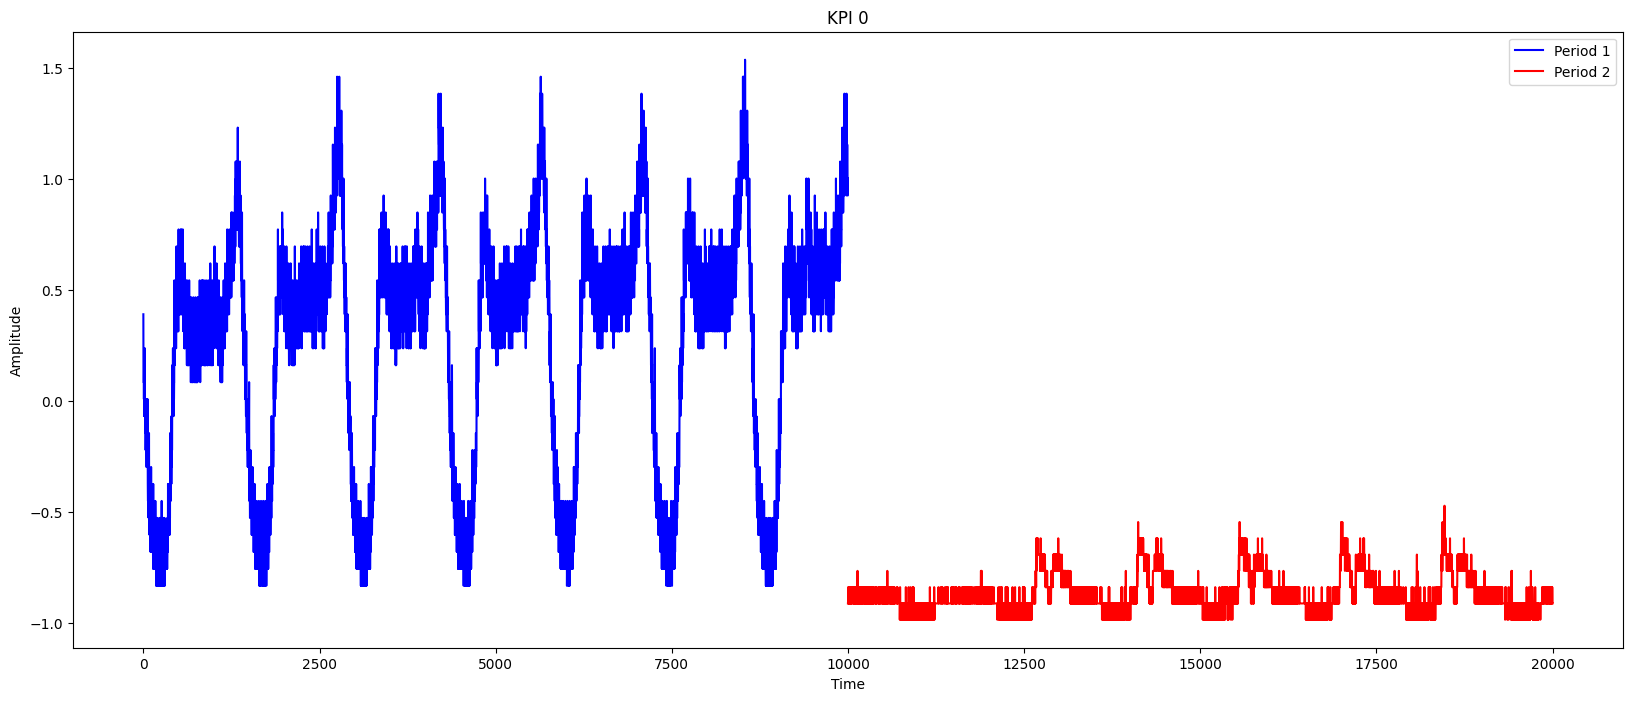

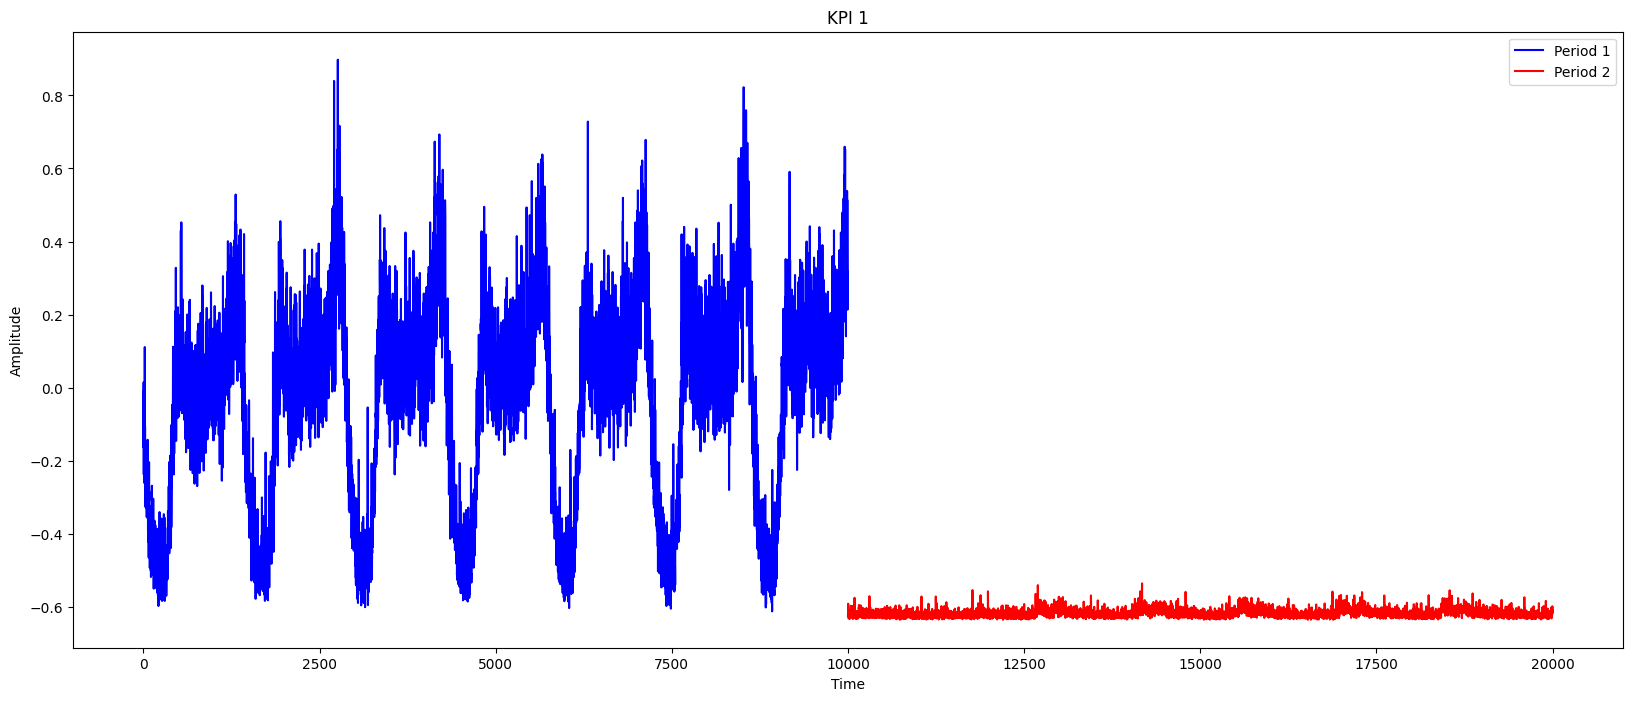

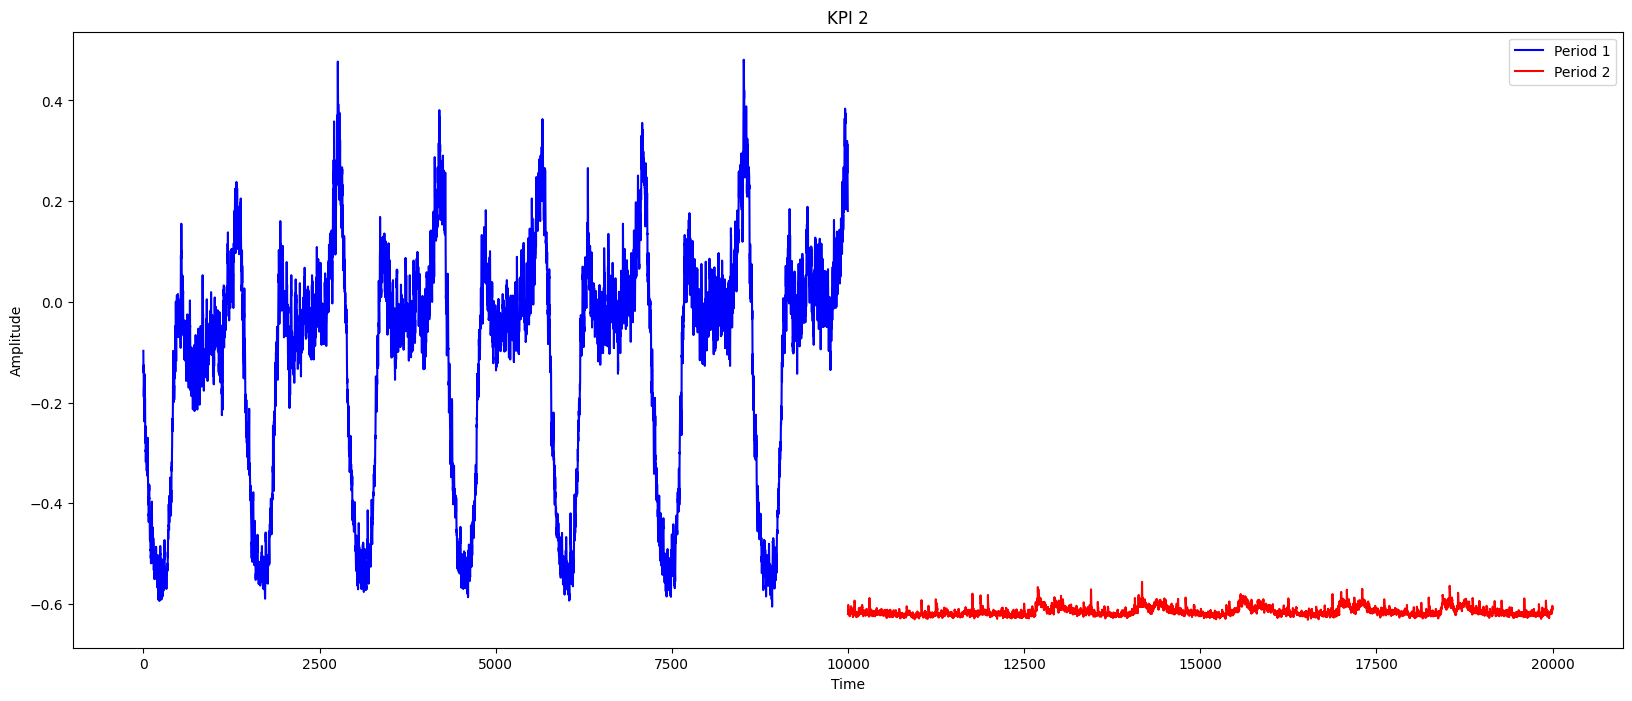

In [6]:
# plot first 3 KPIs
for i in range(3):
    plot_kpi(SMD_dataset_object, i)

In [ ]:
# plot all KPIs
for i in range(SMD_dataset_object.train.shape[1]):
    plot_kpi(SMD_dataset_object, i)

## Anomaly Detection Without Selection

In [5]:
from anomaly_detection.solvers.AnomalyTransformerSolver import AnomalyTransformerSolver

solver = AnomalyTransformerSolver({
    # hyperparameters
    'lr': 1e-4,
    'num_epochs': 10,
    'k': 3,
    'win_size': 100,
    'input_c': kpi_num,
    'output_c': kpi_num,

    # training settings
    'batch_size': 256,
    'patience': 3,

    # testing settings
    "anomaly_ratio": 0.5,

    # data settings
    'dataset': 'SMD',
    'scaler': 'standard',
    'model_save_path': './model_save/',
    'data_path': f'./dataset/SMD/',
    'output_dir': f'./output/SMD/',
    'model_name': 'AnomalyTransformer_SMD',

    "model_init_checkpoint": None,
})


config:  {'lr': 0.0001, 'num_epochs': 10, 'k': 3, 'win_size': 100, 'input_c': 38, 'output_c': 38, 'batch_size': 256, 'patience': 3, 'anomaly_ratio': 0.5, 'dataset': 'SMD', 'scaler': 'standard', 'model_save_path': './model_save/', 'data_path': './dataset/SMD/', 'output_dir': './output/SMD/', 'model_name': 'AnomalyTransformer_SMD', 'model_init_checkpoint': None}


In [ ]:
solver.train()

In [7]:
from torch.utils.data import DataLoader
from anomaly_detection.data_factory.data_loader import TimeSeriesLoader
from anomaly_detection.solvers.AnomalyTransformerSolver import AnomalyTransformerSolver

dataset = "SMD"
data_path = f"./dataset/SMD/"
scaler_class = StandardScaler
dataset_object = get_dataset(data_path, dataset, scaler_class)
test_loader = DataLoader(dataset=TimeSeriesLoader(
    time_series=dataset_object.test[selection_len:, :],
    labels=dataset_object.test_labels[selection_len:],
    win_size=100, step=1),
    shuffle=False, num_workers=0)
solver.load_model()
labels, test_scores, thresh, pred = solver._test_performance(test_loader)


anomaly events: 221 anomaly events hits: 115
origin positives: 3292 predicted events: 2597
anomaly_ratio:  0.5 threshold:  0.00026236352321575354 accuracy:  0.9918495361032674
   precision    recall        f1
0   0.125152  0.017339  0.030459
1   0.886970  0.951138  0.917934
2   0.107432  0.520362  0.178095


In [18]:
solver.test()

======================TEST MODE======================
anomaly events: 327 anomaly events hits: 161
origin positives: 4550 predicted events: 3637
anomaly_ratio:  0.5 threshold:  0.00026236352321575354 accuracy:  0.9913551665725578
   precision    recall        f1
0   0.116484  0.018000  0.031182
1   0.871811  0.928542  0.899283
2   0.094858  0.492355  0.159070
test time: 126.3471


## KPI Sensitivity Calculation

### Train Anomaly Detection Models

In [16]:
# split SMD dataset into datasets of different KPIs
import numpy as np
import os
single_kpi_data_path = "./dataset/SMD_single/"

SMD_dataset_object = load_SMD()

for i in range(kpi_num):
    os.makedirs(single_kpi_data_path + str(i), exist_ok=True)    
    
    np.save(os.path.join(single_kpi_data_path, str(i), "train.npy"), SMD_dataset_object.train[:, i:i+1])
    np.save(os.path.join(single_kpi_data_path, str(i), "test.npy"), SMD_dataset_object.test[:, i:i+1])
    np.save(os.path.join(single_kpi_data_path, str(i), "labels.npy"), SMD_dataset_object.test_labels)


(708405, 38)


In [4]:
import time

from anomaly_detection.solvers.AnomalyTransformerSolver import AnomalyTransformerSolver

def train_model_for_kpi(i):
    print(f"training anomaly detection model for KPI {i}")
    solver = AnomalyTransformerSolver({
        # hyperparameters
        'lr': 1e-4,
        'num_epochs': 10,
        'k': 3,
        'win_size': 100,
        'input_c': 1,
        'output_c': 1,

        # training settings
        'batch_size': 256,
        'patience': 3,

        # testing settings
        "anomaly_ratio": 2.0,

        # data settings
        'dataset': 'SMD',
        'scaler': 'standard',
        'model_save_path': './model_save/',
        'data_path': f'./dataset/SMD_single/{i}/',
        'output_dir': f'./output/SMD_single/{i}/',
        'model_name': f'AnomalyTransformer_SMD_single_{i}',

        "model_init_checkpoint": None,
    })
    start_time = time.time()
    solver.train()
    end_time = time.time()
    return end_time - start_time


In [8]:
# train models
import os
os.system("bash ./scripts/SMD_single.sh")

+ KPI_NUMS=1
+ MODEL_TYPE=transformer
++ seq 8 37
+ for KPI_NUM in $(seq 8 37)
+ DATASET=SMD
+ DATA_PATH=./dataset/SMD_single/8
+ MODEL=transformer_SMD-8
+ OUTPUT_PATH=output/SMD_single/transformer_SMD-8_SMD-8
+ mkdir -p output/SMD_single/transformer_SMD-8_SMD-8
+ python main.py --model_name transformer_SMD-8 --model_type transformer --patience 3 --anomaly_ratio 2 --num_epochs 10 --batch_size 256 --mode train --dataset SMD --data_path ./dataset/SMD_single/8 --input_c 1 --output_c 1 --output_dir output/SMD_single/transformer_SMD-8_SMD-8 --win_size 100 --hidden_size 38


------------ Options -------------
anomaly_ratio: 2.0
batch_size: 256
data_path: ./dataset/SMD_single/8
dataset: SMD
event_output_file: None
hidden_size: 38
input_c: 1
inspect_scores: False
k: 3
lambda_cov: 0.005
lambda_energy: 0.1
log_step: 100
lr: 0.0001
mode: train
model_init_checkpoint: None
model_name: transformer_SMD-8
model_save_path: checkpoints
model_type: transformer
multiple_anomaly_ratios: False
n_gmm: 4
num_epochs: 10
output_c: 1
output_dir: output/SMD_single/transformer_SMD-8_SMD-8
output_file: None
patience: 3
pretrained_model: None
save_input_output: False
scaler: standard
score_method: mse
select_file: None
subset_num: None
win_size: 100
-------------- End ----------------
cuda
config:  {'lr': 0.0001, 'num_epochs': 10, 'k': 3, 'win_size': 100, 'input_c': 1, 'output_c': 1, 'batch_size': 256, 'pretrained_model': None, 'dataset': 'SMD', 'mode': 'train', 'data_path': './dataset/SMD_single/8', 'model_save_path': 'checkpoints', 'anomaly_ratio': 2.0, 'output_dir': 'output/SMD

In [ ]:
# or train models in Jupyter Notebook
for i in range(0, kpi_num):
    train_time = train_model_for_kpi(i)
    print(f"training time for KPI {i}: {train_time:.2f} seconds")

### Detection with trained models

In [4]:
from torch.utils.data import DataLoader
from anomaly_detection.data_factory.data_loader import TimeSeriesLoader
from anomaly_detection.solvers.AnomalyTransformerSolver import AnomalyTransformerSolver

prediction_info = []

for i in range(kpi_num):
    # split the test data set into a set for KPI selection and a set for anomaly detection with a ratio of 3:7
    selection_len = int(SMD_dataset_object.test.shape[0] * 0.3)


    dataset = "SMD"
    data_path = f"./dataset/SMD_single/{i}/"
    scaler_class = StandardScaler
    dataset_object = get_dataset(data_path, dataset, scaler_class)
    selection_loader = DataLoader(dataset=TimeSeriesLoader(
                                            time_series=dataset_object.test[:selection_len, :], 
                                            labels=dataset_object.test_labels[:selection_len], 
                                            win_size=100, step=1),
                                    shuffle=False, num_workers=0)

    print("selection data length:", len(selection_loader))
    print("load model for KPI", i)
    solver = AnomalyTransformerSolver({
        # hyperparameters
        'lr': 1e-4,
        'num_epochs': 10,
        'k': 3,
        'win_size': 100,
        'input_c': 1,
        'output_c': 1,

        # training settings
        'batch_size': 256,
        'patience': 3,

        # testing settings
        "anomaly_ratio": 2.0,

        # data settings
        'dataset': 'SMD',
        'scaler': 'standard',
        'model_save_path': './model_save/',
        'data_path': f'./dataset/SMD_single/{i}/',
        'output_dir': f'./output/SMD_single_selection/{i}/',
        'model_name': f'AnomalyTransformer_SMD_single_{i}',

        "model_init_checkpoint": None,
        "save_output": True
    })

    solver.load_model()
    print("running anomaly detection for KPI", i)
    labels, test_scores, thresh, pred = solver._test_performance(selection_loader)
    
    prediction_info.append((test_scores, thresh, pred))


selection data length: 2125
load model for KPI 0
config:  {'lr': 0.0001, 'num_epochs': 10, 'k': 3, 'win_size': 100, 'input_c': 1, 'output_c': 1, 'batch_size': 256, 'patience': 3, 'anomaly_ratio': 2.0, 'dataset': 'SMD', 'scaler': 'standard', 'model_save_path': './model_save/', 'data_path': './dataset/SMD_single/0/', 'output_dir': './output/SMD_single_selection/0/', 'model_name': 'AnomalyTransformer_SMD_single_0', 'model_init_checkpoint': None, 'save_output': True}
running anomaly detection for KPI 0
anomaly events: 106 anomaly events hits: 43
origin positives: 4357 predicted events: 2448
anomaly_ratio:  2.0 threshold:  9.949304167093824e-06 accuracy:  0.97728
   precision    recall        f1
0   0.028230  0.021643  0.024502
1   0.545854  0.895478  0.678262
2   0.033905  0.405660  0.062580
(212500,) (212500,) (212500,)
selection data length: 2125
load model for KPI 1
config:  {'lr': 0.0001, 'num_epochs': 10, 'k': 3, 'win_size': 100, 'input_c': 1, 'output_c': 1, 'batch_size': 256, 'patien

### Sensitivity Calculation

In [8]:
import numpy as np

from anomaly_detection.utils import read_results

prediction_info = []

dataset_name = "SMD"
anomaly_ratio = 2.0

output_dir = f"./output/SMD_single_selection/"
event_hit_data = []

for i in range(kpi_num):
    if dataset_name is not None:
        dataset = dataset_name
    else:
        dataset = dir.split('_')[-1]
    file_path = os.path.join(
        output_dir, str(i), "events", f"event_results_{dataset}_{anomaly_ratio}.txt")
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist")
        continue
    with open(file_path) as f:
        data = []
        for l in f:
            data.append(int(l))
    event_hit_data.append(data)

event_hit_data = np.array(event_hit_data).astype(np.int_)

In [9]:
kpi_sensitivity = np.mean(event_hit_data, axis=1)
kpi_sensitivity

array([0.39622642, 0.3490566 , 0.3490566 , 0.3490566 , 0.30188679,
       0.36792453, 0.31132075, 0.33018868, 0.48113208, 0.35849057,
       0.33962264, 0.33962264, 0.68867925, 0.50943396, 0.45283019,
       0.37735849, 0.30188679, 0.32075472, 0.30188679, 0.43396226,
       0.3490566 , 0.3490566 , 0.31132075, 0.37735849, 0.35849057,
       0.30188679, 0.41509434, 0.3490566 , 0.31132075, 0.33962264,
       0.30188679, 0.39622642, 0.35849057, 0.37735849, 0.30188679,
       0.30188679, 0.25471698, 0.30188679])

## KPI Clustering

In [10]:
import numpy as np
from anomaly_detection.ts_clustering import clustering_HDBSCAN

train_data = np.load("./dataset/SMD/train.npy")
sbd_matrix, cluster_labels = clustering_HDBSCAN(train_data[0:10000])
cluster_labels

array([ 0,  0,  0,  0,  1,  0,  0,  1, -1, -1, -1, -1, -1,  0, -1,  0,  1,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1, -1,  0,  0, -1, -1,
        0,  0,  1,  1])

## KPI Selection

In [13]:
threshold = np.percentile(kpi_sensitivity, 20)
print("threshold:", threshold)

selected_kpis = np.argwhere(kpi_sensitivity > threshold).flatten()
print("selected_kpis:", selected_kpis)
print("selected KPI number:", len(selected_kpis))

threshold: 0.3018867924528302
selected_kpis: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 26 27
 28 29 31 32 33]
selected KPI number: 29


In [14]:
print(np.array([np.argsort(kpi_sensitivity), np.sort(kpi_sensitivity)]).T[::-1])

[[12.          0.68867925]
 [13.          0.50943396]
 [ 8.          0.48113208]
 [14.          0.45283019]
 [19.          0.43396226]
 [26.          0.41509434]
 [ 0.          0.39622642]
 [31.          0.39622642]
 [23.          0.37735849]
 [33.          0.37735849]
 [15.          0.37735849]
 [ 5.          0.36792453]
 [32.          0.35849057]
 [ 9.          0.35849057]
 [24.          0.35849057]
 [ 1.          0.3490566 ]
 [ 2.          0.3490566 ]
 [ 3.          0.3490566 ]
 [20.          0.3490566 ]
 [21.          0.3490566 ]
 [27.          0.3490566 ]
 [29.          0.33962264]
 [11.          0.33962264]
 [10.          0.33962264]
 [ 7.          0.33018868]
 [17.          0.32075472]
 [ 6.          0.31132075]
 [28.          0.31132075]
 [22.          0.31132075]
 [ 4.          0.30188679]
 [37.          0.30188679]
 [16.          0.30188679]
 [25.          0.30188679]
 [30.          0.30188679]
 [34.          0.30188679]
 [35.          0.30188679]
 [18.          0.30188679]
 

In [29]:
select_values, select_counts = np.unique(cluster_labels[selected_kpis], return_counts=True)
all_values, all_counts = np.unique(cluster_labels, return_counts=True)

print(select_values, select_counts)

cluster_selecting_ratio_threshold = 0.6
selected_clusters = []

for i in range(np.max(cluster_labels)+1):
    select_ratio = select_counts[np.argwhere(select_values == i)[0][0]] / all_counts[np.argwhere(all_values == i)[0][0]]
    print(i, select_ratio)
    if select_ratio > cluster_selecting_ratio_threshold:
        selected_clusters.append(i)
    
print("selected clusters", selected_clusters)
selected_kpis_extended = np.union1d(np.argwhere(
    np.isin(cluster_labels, selected_clusters)), selected_kpis)
print("number of selected KPIs after extended:", len(selected_kpis_extended))
print("selected KPIs after extended:",selected_kpis_extended)
selected_kpis = selected_kpis_extended

[-1  0  1] [ 9 16  4]
0 0.7619047619047619
1 0.5
selected clusters [0]
number of selected KPIs after extended: 34
selected KPIs after extended: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35]


## Anomaly Detection with Selected KPIs

In [30]:
from anomaly_detection.solvers.AnomalyTransformerSolver import AnomalyTransformerSolver

solver = AnomalyTransformerSolver({
    # hyperparameters
    'lr': 1e-4,
    'num_epochs': 3,
    'k': 3,
    'win_size': 100,
    'input_c': len(selected_kpis),
    'output_c': len(selected_kpis),

    # training settings
    'batch_size': 256,
    'patience': 3,

    # testing settings
    "anomaly_ratio": 0.5,

    # data settings
    'dataset': 'SMD',
    'scaler': 'standard',
    'model_save_path': './model_save/',
    'data_path': None,
    'output_dir': f'./output/SMD/',
    'model_name': f'AnomalyTransformer_SMD_select_{threshold:.4f}_{cluster_selecting_ratio_threshold:.4f}',

    "model_init_checkpoint": None,
})


dataset_object = get_dataset(data_path="./dataset/SMD", dataset="SMD", scaler_class=solver.scaler_class)
dataset_object.select_kpis(selected_kpis)
print("selected train dataset shape:", dataset_object.train.shape)

solver.load_dataset_object(dataset_object)

config:  {'lr': 0.0001, 'num_epochs': 10, 'k': 3, 'win_size': 100, 'input_c': 34, 'output_c': 34, 'batch_size': 256, 'patience': 3, 'anomaly_ratio': 0.5, 'dataset': 'SMD', 'scaler': 'standard', 'model_save_path': './model_save/', 'data_path': None, 'output_dir': './output/SMD/', 'model_name': 'AnomalyTransformer_SMD_select_0.3019', 'model_init_checkpoint': None}
selected train dataset shape: (708405, 34)


In [31]:
solver.train()

======================TRAIN MODE======================
	speed: 0.1796s/iter; left time: 4950.6878s
	speed: 0.1790s/iter; left time: 4917.9381s
	speed: 0.1794s/iter; left time: 4911.7099s
	speed: 0.1798s/iter; left time: 4902.9802s
	speed: 0.1800s/iter; left time: 4889.5167s
	speed: 0.1800s/iter; left time: 4871.6345s
	speed: 0.1800s/iter; left time: 4853.5379s
	speed: 0.1800s/iter; left time: 4835.4904s
	speed: 0.1799s/iter; left time: 4817.3429s
	speed: 0.1799s/iter; left time: 4799.3845s
	speed: 0.1799s/iter; left time: 4781.2436s
	speed: 0.1800s/iter; left time: 4763.4943s
	speed: 0.1799s/iter; left time: 4745.2847s
	speed: 0.1799s/iter; left time: 4727.2764s
	speed: 0.1799s/iter; left time: 4709.3653s
	speed: 0.1800s/iter; left time: 4691.5569s
	speed: 0.1801s/iter; left time: 4678.5356s
	speed: 0.1799s/iter; left time: 4655.2540s
	speed: 0.1800s/iter; left time: 4637.5913s
	speed: 0.1799s/iter; left time: 4619.0841s
	speed: 0.1799s/iter; left time: 4601.3575s
	speed: 0.1799s/iter;

In [32]:
dataset = "SMD"
data_path = f"./dataset/SMD/"
scaler_class = StandardScaler
dataset_object = get_dataset(data_path, dataset, scaler_class)
dataset_object.select_kpis(selected_kpis_extended)
test_loader = DataLoader(dataset=TimeSeriesLoader(
    time_series=dataset_object.test[selection_len:, :],
    labels=dataset_object.test_labels[selection_len:],
    win_size=100, step=1),
    shuffle=False, num_workers=0)
solver.load_model()
labels, test_scores, thresh, pred = solver._test_performance(test_loader)


anomaly events: 221 anomaly events hits: 155
origin positives: 5940 predicted events: 2328
anomaly_ratio:  0.5 threshold:  3.597179967982809e-05 accuracy:  0.9887293263412666
                  type  precision    recall        f1
0            origin F1   0.224916  0.056227  0.089963
1  Point Adjustment F1   0.831854  0.958588  0.890736
2             Event F1   0.154210  0.701357  0.252829


In [40]:
solver.test()

======================TEST MODE======================
anomaly events: 327 anomaly events hits: 181
origin positives: 5616 predicted events: 3528
anomaly_ratio:  0.5 threshold:  6.818155197834026e-05 accuracy:  0.9888085827216262
   precision    recall        f1
0   0.205306  0.039159  0.065773
1   0.853393  0.882319  0.867615
2   0.121599  0.553517  0.199394
test time: 131.7814
